## Building a multilayer perceptron for regression in theano

In [422]:
import theano
import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [423]:
import sklearn
from sklearn import datasets

cali_housing = sklearn.datasets.california_housing.fetch_california_housing()

X = cali_housing.data
y = cali_housing.target
Xy = np.vstack((X.T,y)).T

features_and_target = cali_housing.feature_names + ["target"]
features_to_retrieve = cali_housing.feature_names
target_feature = ["target"]
Xy_df = pd.DataFrame(Xy, columns=features_and_target)

In [424]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
            'AveOccup', 'Latitude', 'Longitude']

target = ['target']

In [435]:

X_train = Xy_df[features].as_matrix()
y_train = Xy_df[target].as_matrix()
X_train = sklearn.preprocessing.minmax_scale(X_train)

## Overview mlp

In [475]:
#Dropout
import matplotlib
from matplotlib import pyplot as plt
import mlp_regression

/home/david/Documents/git_stuff/connectionist/MLPRegression/mlp_regression.py:101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(activation in implemented_activations, 'One of the activations was not allowed')


In [476]:
n_features = len(features)
dims = [n_features, 200, 100, 1]
activations = ["relu", "relu", "identity"]

model = mlp_regression.MLPRegression(dims, 
                                     activations=activations , 
                                     learning_rate=0.0001,
                                     dropout_prob=0.1)


In [482]:
model.predict(Xy_df[features][0:5])

array([[ 0.00098005],
       [ 0.00579991],
       [ 0.00140947],
       [ 0.00156663],
       [ 0.00157886]], dtype=float32)

## Testing MLP regression

In [486]:
#Dropout
import matplotlib
from matplotlib import pyplot as plt
import mlp_regression


/home/david/Documents/git_stuff/connectionist/MLPRegression/mlp_regression.py:101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(activation in implemented_activations, 'One of the activations was not allowed')


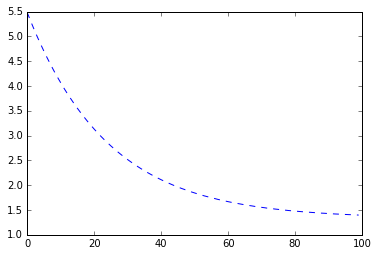

In [487]:
n_features = len(features)
dims = [n_features, 200, 100, 1]
activations = ["relu", "relu", "identity"]

model = mlp_regression.MLPRegression(dims, 
                                     activations=activations , 
                                     learning_rate=0.0001,
                                     dropout_prob=0.5)

n_samples = X_train.shape[0]
batch_size = 200
n_batches = n_samples // batch_size 

import sys
cost_evo = []
for i in range(100):
    cost_minibatch =0
    n_batches = 0
    for ind in range(0, n_samples, batch_size):
        n_batches +=1
        cost_minibatch += model.partial_fit(X_train[ind:ind+batch_size], 
                                               y_train[ind:ind+batch_size])
    
    cost_evo.append(cost_minibatch/n_batches )


plt.plot(cost_evo,"--")

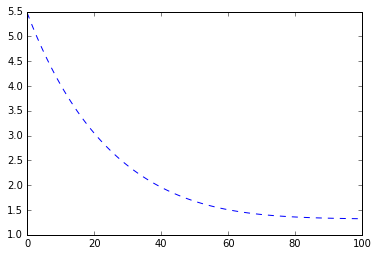

In [485]:
n_features = len(features)
dims = [n_features, 200, 100, 1]
activations = ["relu", "relu", "identity"]

model = mlp_regression.MLPRegression(dims, 
                                     activations=activations , 
                                     learning_rate=0.0001,
                                     dropout_prob=-1)

n_samples = X_train.shape[0]
batch_size = 200
n_batches = n_samples // batch_size 

import sys
cost_evo = []
for i in range(100):
    cost_minibatch =0
    n_batches = 0
    for ind in range(0, n_samples, batch_size):
        n_batches +=1
        cost_minibatch += model.partial_fit(X_train[ind:ind+batch_size], 
                                               y_train[ind:ind+batch_size])
    
    cost_evo.append(cost_minibatch/n_batches )


plt.plot(cost_evo,"--")

In [270]:
import mlp_regression

/home/david/Documents/git_stuff/connectionist/MLPRegression/mlp_regression.py:93: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(activation in implemented_activations, 'One of the activations was not allowed')


In [271]:
n_features = len(features)

In [272]:
dims = [n_features, 200, 100, 1]
activations = ["relu", "relu", "identity"]

In [273]:
model = mlp_regression.MLPRegression(dims, activations, learning_rate=0.0001)

In [274]:
model.predict(Xy_df[features][0:5])

array([[ 0.98005003],
       [ 5.79990864],
       [ 1.40946817],
       [ 1.56663454],
       [ 1.57885885]], dtype=float32)

### Computing MSE

- Check that MSE is computed correctly

In [275]:
from sklearn import metrics
sklearn.metrics.mean_squared_error

<function sklearn.metrics.regression.mean_squared_error>

In [276]:
yhat = model.predict(Xy_df[features][0:5])
y = Xy_df[target][0:5]
sklearn.metrics.mean_squared_error(yhat.flatten(), y)

5.748876570565681

In [277]:
model.compute_cost(Xy_df[features][0:5], Xy_df[target][0:5])

array(5.74887633504458)

In [278]:
model.compute_sym_cost(Xy_df[features][0:5], Xy_df[target][0:5])

mean

### Learning: testing fitting minibatch

In [279]:
model.W[2].shape.eval()

array([100,   1])

In [280]:
model = mlp_regression.MLPRegression(dims, activations, learning_rate=0.001)

In [281]:
model.predict(X_train[0:10])

array([[ 0.98005003],
       [ 5.79990864],
       [ 1.40946817],
       [ 1.56663454],
       [ 1.57885885],
       [ 1.20202112],
       [ 2.81579208],
       [ 2.95755386],
       [ 3.05576658],
       [ 3.84980774]], dtype=float32)

In [282]:
y_train[0:10].ndim

2

In [283]:
#Fits the current minibatch and returns the cost for the current minibatch
model.tfunc_fit_mini_batch(X_train[0:10], y_train[0:10])

array(3.346264362335205, dtype=float32)

In [284]:
model.predict(X_train[0:3])

array([[ -1.03016376],
       [-11.15286541],
       [ -1.87665629]], dtype=float32)

In [285]:
model.tfunc_fit_mini_batch(X_train[0:10], y_train[0:10])

array(62.179298400878906, dtype=float32)

In [286]:
model.predict(X_train[0:10])

array([[  34.44775772],
       [ 239.35980225],
       [  51.73920059],
       [  57.81995773],
       [  58.48978043],
       [  43.53463364],
       [ 110.76134491],
       [ 116.9796524 ],
       [ 121.57762146],
       [ 155.89840698]], dtype=float32)

In [287]:
model.learning_rate

0.001

### 2 Layer MLP 

In [133]:
import theano
from theano import tensor as T

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def relu(X):
    return T.maximum(X, 0.)


def updates_sgd(cost, params):
    """
    Method used to define a list of symbolic updates for theano
    """
    grads = theano.tensor.grad(cost=cost, wrt=params)
    updates = []
    for param,grad in zip(params, grads):
        updates.append([param, param - grad * 0.01 ])

    return updates

In [134]:
n_features = X_train.shape[1]
n_hid = 200
n_out = 1

sha_W1 = theano.shared(floatX(np.random.normal(np.zeros((n_features,n_hid)), scale=0.1)/np.sqrt(n_features)))
sha_b1 = theano.shared(floatX(np.zeros(n_hid)))

sha_W2 = theano.shared(floatX(np.random.normal(np.zeros((n_hid,n_out)), scale=0.1)/np.sqrt(n_out)))
sha_b2 = theano.shared(floatX(np.zeros(1)))

params = [sha_W1, sha_b1, sha_W2, sha_b2]

sym_Xbatch = T.matrix("sym_Xbatch")
sym_Ybatch = T.matrix("sym_Ybatch")

sym_out = T.dot(relu(T.dot(sym_Xbatch, sha_W1) + sha_b1), sha_W2) + sha_b2
sym_cost = T.mean((sym_out - sym_Ybatch)**2)
sym_updates = updates_sgd(sym_cost, params)

tfunc_fitbatch = theano.function(inputs=[sym_Xbatch, sym_Ybatch], 
                                 outputs=sym_cost,
                                 updates=sym_updates,
                                 allow_input_downcast = True)


tfunc_output = theano.function(inputs=[sym_Xbatch], 
                                outputs=[sym_out,], 
                                 allow_input_downcast = True)


In [135]:
#sym_out.eval({"sym_Xbatch":X_train[0:100]})

In [136]:
tfunc_output(X_train[0:2])

[array([[ 2.60931635],
        [ 8.81646347]], dtype=float32)]

In [137]:
X_train = sklearn.preprocessing.minmax_scale(X_train)

In [138]:
import sys
cost_evo = []
for i in range(1000):
    cost_evo.append(tfunc_fitbatch(X_train[0:100], y_train[0:100]))